# Section 4: Machine Learning

In this section, we will deploy several machine learning algorithms to build a classifier (or classifiers) to predict the severity of the car accidents in the U.S. We will also verify some of our observations from the EDA section.

## 4.1 Setting up

Let's import the required libraries!

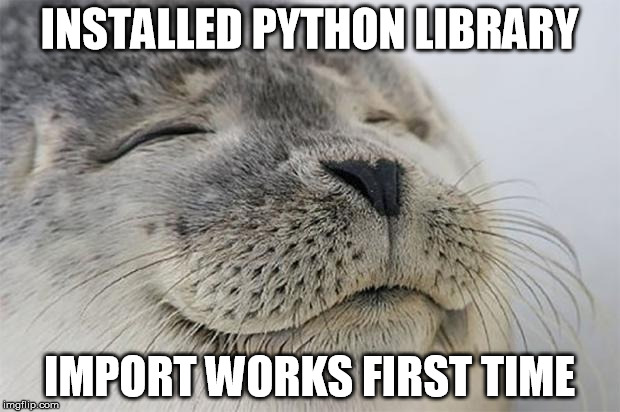

In [ ]:
#@title
#get access to the US car accidents csv file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title
#data wrangling and visualization
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

#machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title
#read the file to a Pandas Dataframe
acc_df = pd.read_csv('/content/drive/MyDrive/US_Accidents_June20.csv')

## 4.2 Feature Exploration

In [ ]:
#@title
acc_df.shape

(3513617, 49)

In [ ]:
#@title
acc_df.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

This is a massive data set with ~3.5 million records and 48 different features. Let's take a look at the top few rows to get a sense about the data.


In [ ]:
#@title
acc_df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


Let's take a closer look at what we're trying to predict, our "y label", or the severity of the accident.

In [ ]:
#@title
severity_count = acc_df['Severity'].value_counts().rename_axis('severity_level').reset_index(name='num_accidents')
severity_count

,severity_level,num_accidents
0,2,2373210
1,3,998913
2,4,112320
3,1,29174


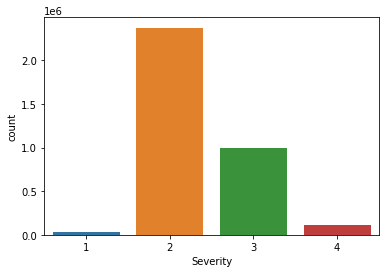

In [ ]:
#@title
sb.countplot(x=acc_df['Severity'])

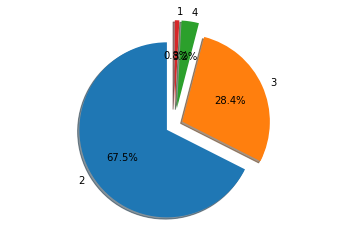

In [ ]:
#@title
explode = (0.1, 0.1, 0.2 ,0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(severity_count['num_accidents'], explode=explode, labels=severity_count['severity_level'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

We note that the majority of the accidents fall into category 2 and 3 in terms of severity. We might have to deal with class imbalance issue.

## 4.3 Feature Engineering

Feature engineering is to use existing features to create new features to determine if they provide new signals to predict the outcome. From the EDA section, we've learned that the time it takes to clear an accident might give us some information about how severe that accident was. Let's try to extract this information!

### 4.3.1 Feature Extraction

In [ ]:
#@title
#convert start time and end time to the right format
acc_df['Start_Time'] = pd.to_datetime(acc_df['Start_Time'], errors='coerce')
acc_df['End_Time'] = pd.to_datetime(acc_df['End_Time'], errors='coerce')

In [ ]:
#@title
#extract year, month, day, hour, and weekday of the accident from start and end time
acc_df['Year']=acc_df['Start_Time'].dt.year
acc_df['Month']=acc_df['Start_Time'].dt.strftime('%b')
acc_df['Day']=acc_df['Start_Time'].dt.day
acc_df['Hour']=acc_df['Start_Time'].dt.hour
acc_df['Weekday']=acc_df['Start_Time'].dt.strftime('%a')

In [ ]:
#@title
#calculate the duration of the accident in minute
acc_df['acc_duration(min)']=round((acc_df['End_Time']-acc_df['Start_Time'])/np.timedelta64(1,'m'))

In [ ]:
#@title
#let's take a look at our new features
acc_df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour,Weekday,acc_duration(min)
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2016,Feb,8,5,Mon,314.0
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,2016,Feb,8,6,Mon,30.0
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,2016,Feb,8,6,Mon,30.0
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,2016,Feb,8,7,Mon,30.0
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,2016,Feb,8,7,Mon,30.0


### 4.3.2 Outlier Analysis

We do a sanity check to find out if there are any outliers we need to handle from this new feature. There are negative durations that should be removed.

In [ ]:
#@title
#records with negative duration
acc_df['acc_duration(min)'][acc_df['acc_duration(min)'] <= 0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
860988    -12.0
861024    -31.0
861041     -0.0
861475    -14.0
861494     -0.0
861495    -30.0
1497823   -30.0
1497824   -31.0
2234574   -30.0
2234659   -30.0
2234660   -31.0
3104499   -34.0
3104975    -7.0
3104978    -7.0
3232740   -31.0
Name: acc_duration(min), dtype: float64

In [ ]:
#@title
#remove the records with negative duration
acc_df['acc_duration(min)'][acc_df['acc_duration(min)'] <= 0] = np.nan
acc_df.dropna(subset=['acc_duration(min)'], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Looking closer at the time it takes to clear an accident, we note something very unusual.

In [ ]:
#@title
acc_df[acc_df['acc_duration(min)']==acc_df['acc_duration(min)'].max()]

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour,Weekday,acc_duration(min)
2740847,A-2740902,Bing,NaN,2,2017-08-16 14:07:14,2020-04-30 01:22:43,40.02935,-80.31546,40.02935,-80.31546,0.0,At PA-231/E Finley Dr - Fuel spillage accident.,1.0,Sparta Rd,R,Prosperity,Washington,PA,15329-1467,US,US/Eastern,KAFJ,2017-08-16 14:15:00,80.6,NaN,54.0,30.08,10.0,Calm,NaN,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,True,False,False,False,Day,Day,Day,Day,2017,Aug,16,14,Wed,1421955.0
2740848,A-2740903,Bing,NaN,2,2017-08-16 14:07:14,2020-04-30 01:22:43,40.02935,-80.31546,40.02935,-80.31546,0.0,At Grove Rd - Fuel spillage accident.,1.0,Sparta Rd,R,Prosperity,Washington,PA,15329-1467,US,US/Eastern,KAFJ,2017-08-16 14:15:00,80.6,NaN,54.0,30.08,10.0,Calm,NaN,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,True,False,False,False,Day,Day,Day,Day,2017,Aug,16,14,Wed,1421955.0


This accident took us almost 3 years to clear! That doesn't seem right. It could be due to some data entry error, or you know, it IS actually the time it took to clear this accident. However, we don't want these outliers to skew our data, so let's remove them. A safe way to do this is to remove any records that have accident duration which is greater than 2 standard deviations way from the mean accident duration.


In [ ]:
#@title
#remove observations that have accident duration which is greater than 2 standard deviation from the mean

outliers = (acc_df['acc_duration(min)'] - acc_df['acc_duration(min)'].mean()).abs() > acc_df['acc_duration(min)'].std()*2
acc_df[outliers] = np.nan
acc_df['acc_duration(min)'].fillna(acc_df['acc_duration(min)'].mean(), inplace=True)

Let's plot out the distribution of the accident duration feature!

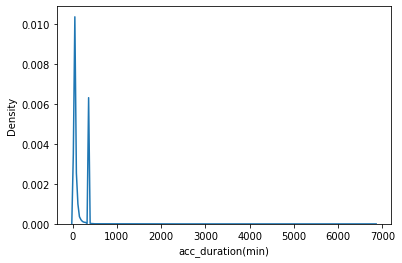

In [ ]:
#@title
sb.kdeplot(data=acc_df, x="acc_duration(min)")

### 4.3.3 Handling Missing Data

There are a lot of missing data in our data set. Missing values can be bad, because some algorithms don't know how-to handle null values and will fail. While others, like decision trees, can handle null values. Thus, it's important to address this problem before we start modeling. There are two common methods, either delete the record or populate the missing value using a reasonable input. In general, it is not recommended to delete the record, especially a large percentage of records, unless it truly represents an incomplete record. The best approach is to impute missing values. Let's take a look at the number of missing values in each column feature.

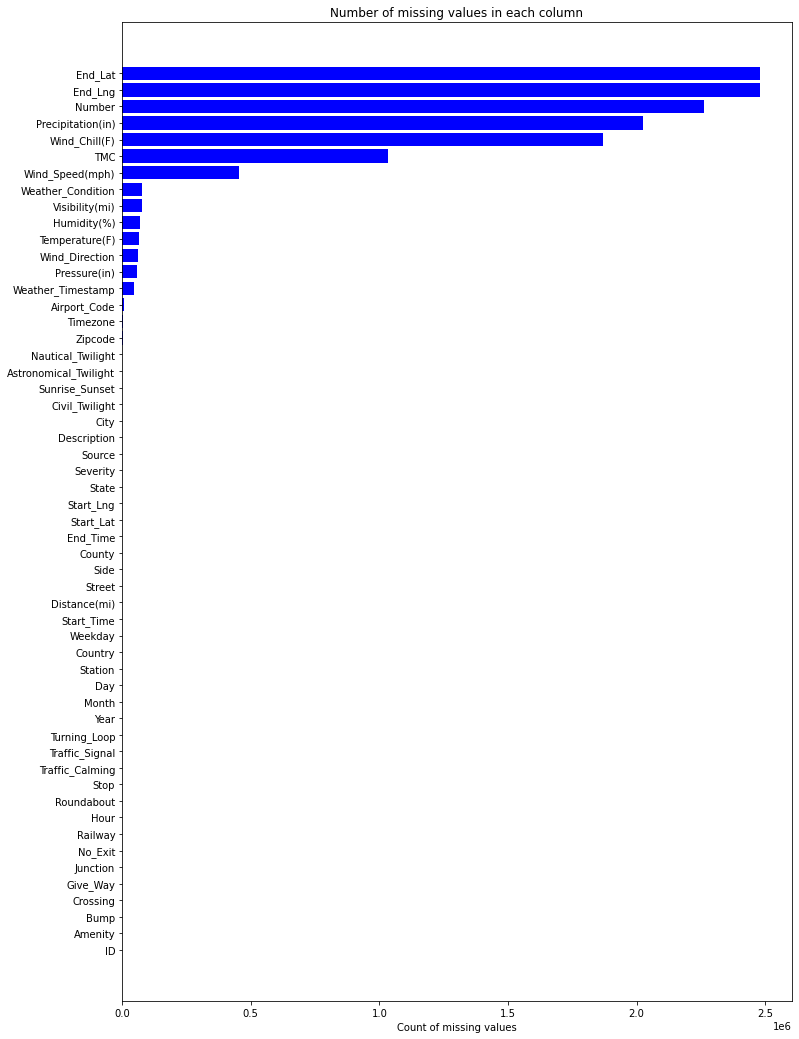

In [ ]:
#@title
missing_df = acc_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

While it's not recommended to drop the records with missing values, we have a lot of data, probably more than what we need to train our classifier. Under the scope of this project, we decided to go with this route. 

Next step is to decide what features we're going to use for our model. We do not include IDs, number, street side, country, timezone, airport, weather time stamp, and other columns with a lot of missing values (end_lat, end_lng, precipitation, etc.) 

In [ ]:
#@title
#exclude ID - no predictive power
#number, street side, country, timezone, airport(?), weather time stamp
#columns with a lot of missing values

#state, airport_code

col_to_use = ['Source', 'TMC', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'County', 'State', 
              'Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition',
              'Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop',
              'Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight',
              'Astronomical_Twilight', 'Hour','Weekday', 'acc_duration(min)', 'Severity']

In [ ]:
#@title
#create a new dataframe with the columns we need
acc_df = acc_df[col_to_use]

Even after dropping all the records with missing values, we are still left with a bit more than 2.4 million records.

In [ ]:
#@title
#drop records with missing values
acc_df.dropna(subset=acc_df.columns[acc_df.isnull().mean()!=0], how='any', axis=0, inplace=True)
acc_df.shape

(2408024, 34)

Due to the massive amount of data, it will take a long time to train our models. We decided to train with a subset of the available data. We filter out all the records from NY state as our chosen subset. Below is a quick look at NY and where the accidents happened.

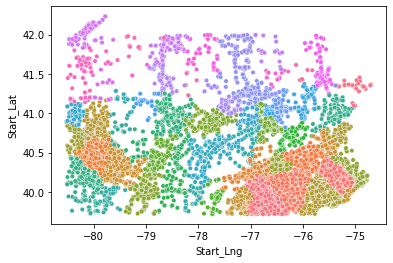

In [ ]:
#@title
state = 'PA'
df_state = acc_df.loc[acc_df['State']==state].copy()
df_state.drop('State',axis=1, inplace=True)
sb.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

In [ ]:
#@title
df_state.head()

,Source,TMC,Start_Lat,Start_Lng,Distance(mi),County,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hour,Weekday,acc_duration(min),Severity
197865,MapQuest,201.0,41.338398,-74.837120,0.01,Pike,28.9,85.0,30.54,3.0,East,Overcast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,Day,Day,Day,14.0,Mon,45.0,3.0
208994,MapQuest,201.0,41.408066,-74.914040,0.00,Pike,66.2,60.0,30.27,10.0,North,Clear,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,Day,Day,Day,9.0,Wed,45.0,2.0
214862,MapQuest,201.0,41.324230,-74.806488,0.00,Pike,75.9,69.0,30.28,10.0,SSE,Clear,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Day,Day,Day,Day,11.0,Wed,45.0,2.0
228550,MapQuest,201.0,40.057697,-76.765587,0.01,York,54.0,100.0,29.70,10.0,ESE,Overcast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,Day,Day,Day,16.0,Wed,45.0,2.0
228553,MapQuest,201.0,40.301609,-75.647789,0.01,Montgomery,57.0,100.0,29.74,8.0,Variable,Overcast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Day,Day,Day,Day,14.0,Wed,130.0,2.0


### 4.3.4 Data Preprocessing

Before training our classifiers, we need to convert categorical values to numeric values, standardize the values, and split the data into training set and testing set. Note that to deal with class imbalance issue, we use stratify method when splitting the data to keep the ratios among different categories.

In [ ]:
#@title
#one-hot encode to convert categorical to numerical
df_state = pd.get_dummies(df_state)
df_state.shape

(84378, 191)

In [ ]:
#@title
#standadize the data
scaler = StandardScaler()
scaler.fit_transform(df_state)
df_state.head()

,TMC,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Hour,acc_duration(min),Severity,Source_MapQuest,Source_MapQuest-Bing,County_Adams,County_Allegheny,County_Armstrong,County_Beaver,County_Bedford,County_Berks,County_Blair,County_Bradford,County_Bucks,County_Butler,County_Cambria,County_Cameron,County_Carbon,County_Centre,...,Weather_Condition_Light Snow,Weather_Condition_Light Snow / Windy,Weather_Condition_Light Thunderstorms and Rain,Weather_Condition_Mist,Weather_Condition_Mostly Cloudy,Weather_Condition_Mostly Cloudy / Windy,Weather_Condition_N/A Precipitation,Weather_Condition_Overcast,Weather_Condition_Partly Cloudy,Weather_Condition_Partly Cloudy / Windy,Weather_Condition_Patches of Fog,Weather_Condition_Rain,Weather_Condition_Rain / Windy,Weather_Condition_Scattered Clouds,Weather_Condition_Shallow Fog,Weather_Condition_Showers in the Vicinity,Weather_Condition_Snow,Weather_Condition_Snow / Windy,Weather_Condition_T-Storm,Weather_Condition_T-Storm / Windy,Weather_Condition_Thunder,Weather_Condition_Thunder in the Vicinity,Weather_Condition_Thunderstorm,Weather_Condition_Thunderstorms and Rain,Weather_Condition_Wintry Mix,Sunrise_Sunset_Day,Sunrise_Sunset_Night,Civil_Twilight_Day,Civil_Twilight_Night,Nautical_Twilight_Day,Nautical_Twilight_Night,Astronomical_Twilight_Day,Astronomical_Twilight_Night,Weekday_Fri,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,Weekday_Wed
197865,201.0,41.338398,-74.837120,0.01,28.9,85.0,30.54,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,45.0,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0
208994,201.0,41.408066,-74.914040,0.00,66.2,60.0,30.27,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,45.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
214862,201.0,41.324230,-74.806488,0.00,75.9,69.0,30.28,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0,45.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
228550,201.0,40.057697,-76.765587,0.01,54.0,100.0,29.70,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,45.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
228553,201.0,40.301609,-75.647789,0.01,57.0,100.0,29.74,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,130.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1


In [ ]:
#@title
#extract y label
y = df_state['Severity']

In [ ]:
#@title
#feature columns
X = df_state.drop('Severity', axis=1)

In [ ]:
#@title
#train-test-split with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## 4.4 Applying Machine Learning 

This is a multi-class classification problem. We have several algorithms to consider. Let's look at each of them and see how they perform with the NY subset.

### 4.4.1 Logistic Regression

In [ ]:
#@title
%%time
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy: ", acc_lr)

Logistic Regression Accuracy:  0.8657027731689974
CPU times: user 4min 55s, sys: 3min 20s, total: 8min 16s
Wall time: 2min 5s


### 4.4.2 K-Nearest Neighbor

In [ ]:
%%time
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred)
print("KNN Accuracy: ", acc_knn)

KNN Accuracy:  0.8064470253614601
CPU times: user 28.7 s, sys: 11.2 ms, total: 28.7 s
Wall time: 28.7 s


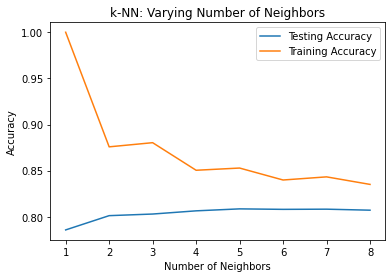

In [ ]:
# find the best k
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, n_neighbor in enumerate(neighbors):

    knn = KNeighborsClassifier(n_neighbors=n_neighbor)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### 4.4.3 Decision Tree

In [ ]:
#@title
%%time
dt = DecisionTreeClassifier(max_depth=10, criterion='entropy')
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy: ", acc_dt)

Decision Tree Accuracy:  0.8922019435885281
CPU times: user 1.14 s, sys: 3.04 ms, total: 1.15 s
Wall time: 1.15 s


### 4.4.4 Random Forest

In [ ]:
#@title
%%time
rf = RandomForestClassifier(n_estimators=200, max_depth=20)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy: ",acc_rf)

Random Forest Accuracy:  0.9007821758710595
CPU times: user 26 s, sys: 50.7 ms, total: 26 s
Wall time: 26 s


A very nice feature available from Sklearn RandomForestClassifier is Feature Importance Graph. From here we can see which features have the biggest impact on determining the severity of the accidents. We can see that our new feature, accident duration, appears in the top 10 features.

No handles with labels found to put in legend.


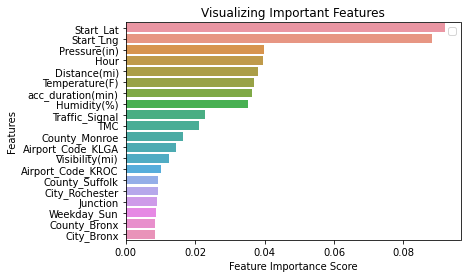

In [ ]:
#@title
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)


k=20
sb.barplot(x=feature_imp[:20], y=feature_imp.index[:k])

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### 4.4.5 GridSearch CV

In [ ]:
#@title
%%time
depth = [10,20,30]
nEstimator = [100,200,300]

grid = {'n_estimators' : nEstimator, 'max_depth': depth}

random_forest = RandomForestClassifier()

grid_search = GridSearchCV(estimator = random_forest, param_grid = grid)
grid_search.fit(X_train,y_train)

y_pred = grid_search.predict(X_test)

acc_grid = accuracy_score(y_test, y_pred)
print("Grid Search Accuracy: ", acc_grid)

Grid Search Accuracy:  0.9090779805641147


### 4.4.6 AdaBoost

In [ ]:
#@title
%%time
ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.01)

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred)
print("AdaBoost Accuracy: ",acc_ada)

AdaBoost Accuracy:  0.7843090779805642
CPU times: user 37.4 s, sys: 211 ms, total: 37.6 s
Wall time: 37.6 s


### 4.4.7 XGBoost

In [ ]:
#@title
#total training time: 4 hours 21 minutes
%%time
gbm = xgb.XGBClassifier(n_estimators= 100, max_depth=10)

gbm.fit(X_train,y_train)

y_pred = gbm.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy: ", acc_xgb)

XGBoost Accuracy:  0.9362408153590899
